# Step 1: Install xvfb & other dependencies

In [2]:
!apt-get install x11-utils > /dev/null 2>&1

In [3]:
!pip install pyglet > /dev/null 2>&1 

In [4]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

# Step 2: Install mujoco

In [5]:
# Include this at the top of your colab code

import os

if not os.path.exists('.mujoco_setup_complete'):
    # Get the prereqs
    !apt-get -qq update
    !apt-get -qq install -y libosmesa6-dev libgl1-mesa-glx libglfw3 libgl1-mesa-dev libglew-dev patchelf
    # Get Mujoco
    !mkdir ~/.mujoco
    !wget -q https://mujoco.org/download/mujoco210-linux-x86_64.tar.gz -O mujoco.tar.gz
    !tar -zxf mujoco.tar.gz -C "$HOME/.mujoco"
    !rm mujoco.tar.gz
    # Add it to the actively loaded path and the bashrc path (these only do so much)
    !echo 'export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$HOME/.mujoco/mujoco210/bin' >> ~/.bashrc 
    !echo 'export LD_PRELOAD=$LD_PRELOAD:/usr/lib/x86_64-linux-gnu/libGLEW.so' >> ~/.bashrc 
    # THE ANNOYING ONE, FORCE IT INTO LDCONFIG SO WE ACTUALLY GET ACCESS TO IT THIS SESSION
    !echo "/root/.mujoco/mujoco210/bin" > /etc/ld.so.conf.d/mujoco_ld_lib_path.conf
    !ldconfig
    # Install Mujoco-py
    !pip3 install -U 'mujoco-py<2.2,>=2.1'
    # run once
    !touch .mujoco_setup_complete

try:
    if _mujoco_run_once:
        pass
except NameError:
    _mujoco_run_once = False
    
if not _mujoco_run_once:
    # Add it to the actively loaded path and the bashrc path (these only do so much)
    try:
        os.environ['LD_LIBRARY_PATH']=os.environ['LD_LIBRARY_PATH'] + ':/root/.mujoco/mujoco210/bin'
    except KeyError:
        os.environ['LD_LIBRARY_PATH']='/root/.mujoco/mujoco210/bin'
    try:
        os.environ['LD_PRELOAD']=os.environ['LD_PRELOAD'] + ':/usr/lib/x86_64-linux-gnu/libGLEW.so'
    except KeyError:
        os.environ['LD_PRELOAD']='/usr/lib/x86_64-linux-gnu/libGLEW.so'
    # presetup so we don't see output on first env initialization
    import mujoco_py
    _mujoco_run_once = True

# Step 3: Install pyvirtual display

In [6]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install -U gym>=0.21.0
!pip install -U gym[atari,accept-rom-license]
!pip install -U gym[Robotics,classic_control]

In [7]:
!pip install gym-robotics

In [8]:
!pip3 install box2d-py
!pip3 install gym[Box_2D]

# Test your environment

In [9]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [10]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

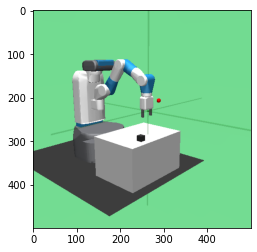

In [11]:
# env = gym.make("CartPole-v0")
# env = gym.make("DoubleDunk-v0")
# env = gym.make("SpaceInvaders-v0")
# env = gym.make("Acrobot-v1") # double invert pendulum
# env = gym.make("Ant-v2")
env = gym.make("FetchPickAndPlace-v1")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(20):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    screen = env.render(mode='rgb_array')

    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

    if done:
        break

ipythondisplay.clear_output(wait=True)
env.close()

# Save simulator video

In [12]:
import os
import gym
from gym.wrappers import RecordVideo

vdo_path = 'video_rl/'
if not os.path.exists(vdo_path):
    os.mkdir(vdo_path)

# env = gym.make("CartPole-v0")
# env = gym.make("DoubleDunk-v0")
# env = gym.make("SpaceInvaders-v0")
# env = gym.make("Acrobot-v1") # double invert pendulum
# env = gym.make("Ant-v2")

env = RecordVideo(gym.make('Ant-v3'), vdo_path)
env.reset()

for i in range(500):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    screen = env.render()
    if done:
        break

env.close()

/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:42: UserWarning: WARN: Overwriting existing videos at /content/video_rl folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)"
/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:116: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  '`env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` '


Creating window glfw


# Policy Gradient and Actor-Critic methods

### CartPole example

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import sys

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.distributions import Categorical

from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

import os
from gym.wrappers import RecordVideo

vdo_path = 'video_rl/'
if not os.path.exists(vdo_path):
    os.mkdir(vdo_path)

In [14]:
gamma = 0.95
seed = 0
render = False
log_interval = 10

In [15]:
env = gym.make("CartPole-v1")
#env = gym.make("SpaceInvaders-v0")
env.seed(seed)
torch.manual_seed(seed)

/usr/local/lib/python3.7/dist-packages/gym/core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "


### Policy class

In [16]:
class Policy(nn.Module):
    def __init__(self, env):
        super(Policy, self).__init__()
        self.n_inputs = env.observation_space.shape[0]
        #print(self.n_inputs)
        self.n_outputs = env.action_space.n
      
        
        self.affine1 = nn.Linear(self.n_inputs, 128)
        self.dropout = nn.Dropout(p=0.6)
        self.affine2 = nn.Linear(128, self.n_outputs)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = self.affine1(x)
        x = self.dropout(x)
        x = F.relu(x)
        #print(x.shape)
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)
    
    def select_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        policy.saved_log_probs.append(m.log_prob(action))
        return action.item()

In [17]:
policy = Policy(env)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
eps = np.finfo(np.float32).eps.item()

In [18]:
def finish_episode():
    R = 0
    policy_loss = []
    returns = []
    for r in policy.rewards[::-1]:
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)
    for log_prob, R in zip(policy.saved_log_probs, returns):
        policy_loss.append(-log_prob * R)
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_log_probs[:]

In [19]:
from itertools import count
def reinforce():
    running_reward = 10
    for i_episode in count(1):
        state, ep_reward = env.reset(), 0
        for t in range(1, 10000):  # Don't infinite loop while learning
            action = policy.select_action(state)
            state, reward, done, _ = env.step(action)
            if render:
                env.render()
            policy.rewards.append(reward)
            ep_reward += reward
            if done:
                break

        # calculate reward
        # It accepts a list of rewards for the whole episode and needs to calculate 
        # the discounted total reward for every step. To do this efficiently,
        # we calculate the reward from the end of the local reward list.
        # The last step of the episode will have the total reward equal to its local reward.
        # The step before the last will have the total reward of ep_reward + gamma * running_reward
        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
        finish_episode()
        if i_episode % log_interval == 0:
            print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                  i_episode, ep_reward, running_reward))
        if running_reward > env.spec.reward_threshold:
            print("Solved! Running reward is now {} and "
                  "the last episode runs to {} time steps!".format(running_reward, t))
            break

In [20]:
reinforce()
env.close()

Episode 10	Last reward: 36.00	Average reward: 13.12
Episode 20	Last reward: 41.00	Average reward: 18.79
Episode 30	Last reward: 123.00	Average reward: 26.18
Episode 40	Last reward: 110.00	Average reward: 35.54
Episode 50	Last reward: 48.00	Average reward: 53.41
Episode 60	Last reward: 161.00	Average reward: 85.45
Episode 70	Last reward: 39.00	Average reward: 102.08
Episode 80	Last reward: 239.00	Average reward: 133.65
Episode 90	Last reward: 66.00	Average reward: 115.97
Episode 100	Last reward: 106.00	Average reward: 100.27
Episode 110	Last reward: 63.00	Average reward: 83.99
Episode 120	Last reward: 83.00	Average reward: 86.38
Episode 130	Last reward: 282.00	Average reward: 140.05
Episode 140	Last reward: 118.00	Average reward: 157.58
Episode 150	Last reward: 305.00	Average reward: 187.27
Episode 160	Last reward: 305.00	Average reward: 214.26
Episode 170	Last reward: 178.00	Average reward: 232.04
Episode 180	Last reward: 50.00	Average reward: 155.10
Episode 190	Last reward: 36.00	Aver

In [21]:
env = RecordVideo(gym.make("CartPole-v1"), vdo_path)
is_done = False
state = env.reset()
while not is_done:
    action = policy.select_action(state)
    
    state, reward, is_done, info = env.step(action)
    # print(reward, is_done)
    screen = env.render(mode='rgb_array')
env.close()

/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:42: UserWarning: WARN: Overwriting existing videos at /content/video_rl folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)"
/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:116: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  '`env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` '


# Policy Gradinet (PG)

### PG on CartPole

In [22]:
import gym
from collections import namedtuple


class PolicyNet(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_layer_size=64):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_layer_size)
        self.fc2 = torch.nn.Linear(hidden_layer_size, output_size)
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, x):
        x = torch.from_numpy(x).float()
        return self.softmax(self.fc2(torch.nn.functional.relu(self.fc1(x))))

    def get_action_and_logp(self, x):
        action_prob = self.forward(x)
        m = torch.distributions.Categorical(action_prob)
        action = m.sample()
        logp = m.log_prob(action)
        return action.item(), logp

    def act(self, x):
        action, _ = self.get_action_and_logp(x)
        return action


class ValueNet(torch.nn.Module):
    def __init__(self, input_size, hidden_layer_size=64):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_layer_size)
        self.fc2 = torch.nn.Linear(hidden_layer_size, 1)

    def forward(self, x):
        x = torch.from_numpy(x).float()
        return self.fc2(torch.nn.functional.relu(self.fc1(x)))


def vpg(env, num_iter=200, num_traj=10, max_num_steps=1000, gamma=0.98,
        policy_learning_rate=0.01, value_learning_rate=0.01,
        policy_saved_path='vpg_policy.pt', value_saved_path='vpg_value.pt'):
    input_size = env.observation_space.shape[0]
    output_size = env.action_space.n
    Trajectory = namedtuple('Trajectory', 'states actions rewards dones logp')

    def collect_trajectory():
        state_list = []
        action_list = []
        reward_list = []
        dones_list = []
        logp_list = []
        state = env.reset()
        done = False
        steps = 0
        while not done and steps <= max_num_steps:
            action, logp = policy.get_action_and_logp(state)
            newstate, reward, done, _ = env.step(action)
            #reward = reward + float(state[0])
            state_list.append(state)
            action_list.append(action)
            reward_list.append(reward)
            dones_list.append(done)
            logp_list.append(logp)
            steps += 1
            state = newstate

        traj = Trajectory(states=state_list, actions=action_list,
                          rewards=reward_list, logp=logp_list, dones=dones_list)
        return traj

    def calc_returns(rewards):
        dis_rewards = [gamma**i * r for i, r in enumerate(rewards)]
        return [sum(dis_rewards[i:]) for i in range(len(dis_rewards))]

    policy = PolicyNet(input_size, output_size)
    value = ValueNet(input_size)
    policy_optimizer = torch.optim.Adam(
        policy.parameters(), lr=policy_learning_rate)
    value_optimizer = torch.optim.Adam(
        value.parameters(), lr=value_learning_rate)

    mean_return_list = []
    for it in range(num_iter):
        traj_list = [collect_trajectory() for _ in range(num_traj)]
        returns = [calc_returns(traj.rewards) for traj in traj_list]

        policy_loss_terms = [-1. * traj.logp[j] * (returns[i][j] - value(traj.states[j]))
                             for i, traj in enumerate(traj_list) for j in range(len(traj.actions))]

        policy_loss = 1. / num_traj * torch.cat(policy_loss_terms).sum()
        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        value_loss_terms = [1. / len(traj.actions) * (value(traj.states[j]) - returns[i][j])**2.
                            for i, traj in enumerate(traj_list) for j in range(len(traj.actions))]
        value_loss = 1. / num_traj * torch.cat(value_loss_terms).sum()
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()

        mean_return = 1. / num_traj * \
            sum([traj_returns[0] for traj_returns in returns])
        mean_return_list.append(mean_return)
        if it % 10 == 0:
            print('Iteration {}: Mean Return = {}'.format(it, mean_return))
            torch.save(policy.state_dict(), policy_saved_path)
            torch.save(value.state_dict(), value_saved_path)
    return policy, mean_return_list

video_rl2/ existed, do nothing
Iteration 0: Mean Return = 18.0


/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:506: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  f"The environment {path} is out of date. You should consider "


Iteration 10: Mean Return = 44.400000000000006
Iteration 20: Mean Return = 39.0
Iteration 30: Mean Return = 51.0
Iteration 40: Mean Return = 59.800000000000004
Iteration 50: Mean Return = 83.4
Iteration 60: Mean Return = 154.60000000000002
Iteration 70: Mean Return = 122.2
Iteration 80: Mean Return = 113.60000000000001
Iteration 90: Mean Return = 199.4
Iteration 100: Mean Return = 200.0
Iteration 110: Mean Return = 200.0
Iteration 120: Mean Return = 200.0
Iteration 130: Mean Return = 200.0
Iteration 140: Mean Return = 167.0
Iteration 150: Mean Return = 190.8
Iteration 160: Mean Return = 200.0
Iteration 170: Mean Return = 200.0
Iteration 180: Mean Return = 200.0
Iteration 190: Mean Return = 200.0


/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:42: UserWarning: WARN: Overwriting existing videos at /content/video_rl2 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)"
/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:116: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  '`env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` '


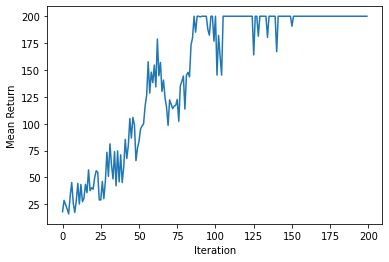

In [23]:
import gym
import matplotlib.pyplot as plt

vdo_path = 'video_rl2/'
if not os.path.exists(vdo_path):
    print("No folder ", vdo_path, 'exist. Create the folder')
    os.mkdir(vdo_path)
    print("Create directory finished")
else:
    print(vdo_path, 'existed, do nothing')

env = gym.make('CartPole-v0')

agent, mean_return_list = vpg(env, num_iter=200, max_num_steps=500, gamma=1.0,
                              num_traj=5)

#env = RecordVideo(gym.make("CartPole-v1"), vdo_path, force=True)
env = RecordVideo(gym.make("CartPole-v1"), vdo_path)

plt.plot(mean_return_list)
plt.xlabel('Iteration')
plt.ylabel('Mean Return')
plt.savefig('vpg_returns.png', format='png', dpi=300)

state = env.reset()
for t in range(1000):
    action = agent.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break
env.close()

# Actor-Critic

# Basic CartPole A2C

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import os
import gym

In [25]:
# Hyper Parameters
STATE_DIM = 4
ACTION_DIM = 2
STEP = 2000
SAMPLE_NUMS = 30

In [26]:
class ActorNetwork(nn.Module):

    def __init__(self,input_size,hidden_size,action_size):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.fc3 = nn.Linear(hidden_size,action_size)

    def forward(self,x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.log_softmax(self.fc3(out))
        return out

In [27]:
class ValueNetwork(nn.Module):

    def __init__(self,input_size,hidden_size,output_size):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.fc3 = nn.Linear(hidden_size,output_size)

    def forward(self,x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [28]:
def roll_out(actor_network,task,sample_nums,value_network,init_state):
    #task.reset()
    states = []
    actions = []
    rewards = []
    is_done = False
    final_r = 0
    state = init_state

    for j in range(sample_nums):
        states.append(state)
        log_softmax_action = actor_network(Variable(torch.Tensor([state])))
        softmax_action = torch.exp(log_softmax_action)
        action = np.random.choice(ACTION_DIM,p=softmax_action.cpu().data.numpy()[0])
        one_hot_action = [int(k == action) for k in range(ACTION_DIM)]
        next_state,reward,done,_ = task.step(action)
        #fix_reward = -10 if done else 1
        actions.append(one_hot_action)
        rewards.append(reward)
        final_state = next_state
        state = next_state
        if done:
            is_done = True
            state = task.reset()
            break
    if not is_done:
        final_r = value_network(Variable(torch.Tensor([final_state]))).cpu().data.numpy()

    return states,actions,rewards,final_r,state

In [29]:
def discount_reward(r, gamma,final_r):
    discounted_r = np.zeros_like(r)
    running_add = final_r
    for t in reversed(range(0, len(r))):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [30]:
def A2C():
    # init a task generator for data fetching
    task = gym.make("CartPole-v0")
    init_state = task.reset()

    # init value network
    value_network = ValueNetwork(input_size = STATE_DIM,hidden_size = 40,output_size = 1)
    value_network_optim = torch.optim.Adam(value_network.parameters(),lr=0.01)

    # init actor network
    actor_network = ActorNetwork(STATE_DIM,40,ACTION_DIM)
    actor_network_optim = torch.optim.Adam(actor_network.parameters(),lr = 0.01)

    steps =[]
    task_episodes =[]
    test_results =[]

    for step in range(STEP):
        states,actions,rewards,final_r,current_state = roll_out(actor_network,task,SAMPLE_NUMS,value_network,init_state)
        init_state = current_state
        actions_var = Variable(torch.Tensor(actions).view(-1,ACTION_DIM))
        states_var = Variable(torch.Tensor(states).view(-1,STATE_DIM))

        # train actor network
        actor_network_optim.zero_grad()
        log_softmax_actions = actor_network(states_var)
        vs = value_network(states_var).detach()
        # calculate qs
        qs = Variable(torch.Tensor(discount_reward(rewards,0.99,final_r)))

        advantages = qs - vs
        actor_network_loss = - torch.mean(torch.sum(log_softmax_actions*actions_var,1)* advantages)
        actor_network_loss.backward()
        torch.nn.utils.clip_grad_norm(actor_network.parameters(),0.5)
        actor_network_optim.step()

        # train value network
        value_network_optim.zero_grad()
        target_values = qs
        values = value_network(states_var)
        criterion = nn.MSELoss()
        value_network_loss = criterion(values,target_values)
        value_network_loss.backward()
        torch.nn.utils.clip_grad_norm(value_network.parameters(),0.5)
        value_network_optim.step()

        # Testing
        if (step + 1) % 50== 0:
                result = 0
                test_task = gym.make("CartPole-v0")
                for test_epi in range(10):
                    state = test_task.reset()
                    for test_step in range(200):
                        softmax_action = torch.exp(actor_network(Variable(torch.Tensor([state]))))
                        #print(softmax_action.data)
                        action = np.argmax(softmax_action.data.numpy()[0])
                        next_state,reward,done,_ = test_task.step(action)
                        result += reward
                        state = next_state
                        if done:
                            break
                print("step:",step+1,"test result:",result/10.0)
                steps.append(step+1)
                test_results.append(result/10)
                
    return actor_network

In [31]:
actor_network = A2C()

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:506: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  f"The environment {path} is out of date. You should consider "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.cli

step: 50 test result: 25.5


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


step: 100 test result: 15.6


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


step: 150 test result: 9.5


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


step: 200 test result: 8.9
step: 250 test result: 38.4


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


step: 300 test result: 61.8
step: 350 test result: 13.0
step: 400 test result: 31.3
step: 450 test result: 89.1
step: 500 test result: 194.0
step: 550 test result: 198.3
step: 600 test result: 44.0
step: 650 test result: 200.0
step: 700 test result: 81.6
step: 750 test result: 200.0
step: 800 test result: 53.9
step: 850 test result: 200.0
step: 900 test result: 167.7
step: 950 test result: 24.2
step: 1000 test result: 44.3
step: 1050 test result: 183.4
step: 1100 test result: 136.1
step: 1150 test result: 193.6
step: 1200 test result: 198.9
step: 1250 test result: 195.3
step: 1300 test result: 163.5
step: 1350 test result: 58.7
step: 1400 test result: 87.8
step: 1450 test result: 114.6
step: 1500 test result: 200.0
step: 1550 test result: 197.4
step: 1600 test result: 131.7
step: 1650 test result: 149.4
step: 1700 test result: 129.2
step: 1750 test result: 200.0
step: 1800 test result: 200.0
step: 1850 test result: 200.0
step: 1900 test result: 200.0
step: 1950 test result: 200.0
step:

In [32]:
vdo_path = 'video_rl3/'
if not os.path.exists(vdo_path):
    os.mkdir(vdo_path)

env = RecordVideo(gym.make("CartPole-v1"), vdo_path)

state = env.reset()
for t in range(1000):
    softmax_action = torch.exp(actor_network(Variable(torch.Tensor([state]))))
    #print(softmax_action.data)
    action = np.argmax(softmax_action.data.numpy()[0])
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break
env.close()

/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:42: UserWarning: WARN: Overwriting existing videos at /content/video_rl3 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)"
/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:116: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  '`env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as 

# Take Home Exercise

Implement REINFORCE and A2C for one of the Atari games such as Space Invaders using a CNN for the policy network and (for A2C) the value network.

### REINFORCE for Space Invaders using a CNN for policy Network

For this part of exercixe, I used 'SpaceInvaders-v0' for environemnt. In policy Net class, the flatten value, 100800, is used for inputs to pass through the linear. Moreover, making reshape for state in select_action finction since SapceInvaders has only 3 dimensioanl inputs.

In [33]:
env = gym.make('SpaceInvaders-v0')
#env = gym.make("CartPole-v1")
env.seed(seed = seed)
torch.manual_seed(seed = seed)

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:506: UserWarning: WARN: The environment SpaceInvaders-v0 is out of date. You should consider upgrading to version `v5` with the environment ID `ALE/SpaceInvaders-v5`.
  f"The environment {path} is out of date. You should consider "
/usr/local/lib/python3.7/dist-packages/gym/utils/seeding.py:139: DeprecationWarning: WARN: Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. 
  "Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. "
/usr/local/lib/python3.7/dist-packages/gym/utils/seeding.py:176: DeprecationWarning: WARN: Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. 
  "Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. "


In [34]:
class Policy(nn.Module):
    def __init__(self, env):
        super(Policy, self).__init__()
        self.n_inputs = env.observation_space.shape[0]
        #print(self.n_inputs)
        self.n_outputs = env.action_space.n
      
        self.affine1 = nn.Linear(100800, 128)
        #self.affine1 = nn.Linear(self.n_inputs, 128)
        self.dropout = nn.Dropout(p=0.6)
        self.affine2 = nn.Linear(128, self.n_outputs)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = self.affine1(x)
        x = self.dropout(x)
        x = F.relu(x)
        #print(x.shape)
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)
    
    def select_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        state = state.reshape((1,-1))
        probs = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        policy.saved_log_probs.append(m.log_prob(action))
        return action.item()

In [35]:
policy = Policy(env)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
eps = np.finfo(np.float32).eps.item()

In [36]:
def finish_episode():
    R = 0
    policy_loss = []
    returns = []
    for r in policy.rewards[::-1]:
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)
    for log_prob, R in zip(policy.saved_log_probs, returns):
        policy_loss.append(-log_prob * R)
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_log_probs[:]

In [37]:
from itertools import count
def reinforce_():
    running_reward = 10
    for i_episode in count(1):
        state, ep_reward = env.reset(), 0
        for t in range(1, 1000):  # Don't infinite loop while learning
            action = policy.select_action(state)
            state, reward, done, _ = env.step(action)
            if render:
                env.render()
            policy.rewards.append(reward)
            ep_reward += reward
            if done:
                break

        # calculate reward
        # It accepts a list of rewards for the whole episode and needs to calculate 
        # the discounted total reward for every step. To do this efficiently,
        # we calculate the reward from the end of the local reward list.
        # The last step of the episode will have the total reward equal to its local reward.
        # The step before the last will have the total reward of ep_reward + gamma * running_reward
        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
        finish_episode()
        if i_episode % log_interval == 0:
            print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                  i_episode, ep_reward, running_reward))
        if running_reward > 100: #env.spec.reward_threshold -->100
            print("Solved! Running reward is now {} and "
                  "the last episode runs to {} time steps!".format(running_reward, t))
            break

In [38]:
reinforce_()
env.close()

/usr/local/lib/python3.7/dist-packages/gym/utils/seeding.py:48: DeprecationWarning: WARN: Function `rng.randint(low, [high, size, dtype])` is marked as deprecated and will be removed in the future. Please use `rng.integers(low, [high, size, dtype])` instead.
  "Function `rng.randint(low, [high, size, dtype])` is marked as deprecated "


Episode 10	Last reward: 210.00	Average reward: 74.83
Solved! Running reward is now 106.36156970938475 and the last episode runs to 982 time steps!


For the result, with Episode 10, Last reward is 210.00 and Average reward is 74.83. Then, Running reward is now 106.36156970938475 and the last episode runs to 982 time steps.

In [39]:
env = RecordVideo(gym.make("SpaceInvaders-v0"), vdo_path)
is_done = False
state = env.reset()
while not is_done:
    action = policy.select_action(state)
    
    state, reward, is_done, info = env.step(action)
    # print(reward, is_done)
    screen = env.render(mode='rgb_array')
env.close()

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:506: UserWarning: WARN: The environment SpaceInvaders-v0 is out of date. You should consider upgrading to version `v5` with the environment ID `ALE/SpaceInvaders-v5`.
  f"The environment {path} is out of date. You should consider "
/usr/local/lib/python3.7/dist-packages/gym/utils/seeding.py:139: DeprecationWarning: WARN: Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. 
  "Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. "
/usr/local/lib/python3.7/dist-packages/gym/utils/seeding.py:176: DeprecationWarning: WARN: Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. 
  "Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. "
/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:42: UserWarning: WARN: Overwriting existing videos at /c

### A2C for Space Invaders using a CNN for value Network

For this part of exercise, I used 100800 which is the flatten result of 'SpaceInvaders-v0' for state dimension. Moreover, making reshape for input in forward function since the input shape of 'SpaceInvaders-v0' is only three dimenions.



In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import os
import gym

In [42]:
# Hyper Parameters
STATE_DIM = 100800
# STATE_DIM = 3
ACTION_DIM = 6
STEP = 10
SAMPLE_NUMS = 1

In [43]:
class ActorNetwork(nn.Module):

    def __init__(self,input_size,hidden_size,action_size):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.fc3 = nn.Linear(hidden_size,action_size)

    def forward(self,x):
        x = x.reshape((1, -1))
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.log_softmax(self.fc3(out))
        return out

In [44]:
class ValueNetwork(nn.Module):

    def __init__(self,input_size,hidden_size,output_size):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.fc3 = nn.Linear(hidden_size,output_size)

    def forward(self,x):
        x = x.reshape((1, -1))
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out


In [45]:
def roll_out(actor_network,task,sample_nums,value_network,init_state):
    #task.reset()
    states = []
    actions = []
    rewards = []
    is_done = False
    final_r = 0
    state = init_state

    for j in range(sample_nums):
        states.append(state)
        log_softmax_action = actor_network(Variable(torch.Tensor([state])))
        softmax_action = torch.exp(log_softmax_action)
        action = np.random.choice(ACTION_DIM,p=softmax_action.cpu().data.numpy()[0])
        one_hot_action = [int(k == action) for k in range(ACTION_DIM)]
        next_state,reward,done,_ = task.step(action)
        #fix_reward = -10 if done else 1
        actions.append(one_hot_action)
        rewards.append(reward)
        final_state = next_state
        state = next_state
        if done:
            is_done = True
            state = task.reset()
            break
    if not is_done:
        final_r = value_network(Variable(torch.Tensor([final_state]))).cpu().data.numpy()

    return states,actions,rewards,final_r,state

In [46]:
def discount_reward(r, gamma,final_r):
    discounted_r = np.zeros_like(r)
    running_add = final_r
    for t in reversed(range(0, len(r))):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r


In [50]:
def A2C():
    # init a task generator for data fetching
    task = gym.make("SpaceInvaders-v0")
    init_state = task.reset()

    # init value network
    value_network = ValueNetwork(input_size = 100800,hidden_size = 40,output_size = 1)
    value_network_optim = torch.optim.Adam(value_network.parameters(),lr=0.01)

    # init actor network
    actor_network = ActorNetwork(100800,40,ACTION_DIM)
    actor_network_optim = torch.optim.Adam(actor_network.parameters(),lr = 0.01)

    steps =[]
    task_episodes =[]
    test_results =[]

    for step in range(STEP):
        states,actions,rewards,final_r,current_state = roll_out(actor_network,task,SAMPLE_NUMS,value_network,init_state)
        init_state = current_state
        actions_var = Variable(torch.Tensor(actions).view(-1,ACTION_DIM))
        states_var = Variable(torch.Tensor(states).view(-1,STATE_DIM))
        #print(actions_var.shape)
        #print(states_var.shape)

        # train actor network
        actor_network_optim.zero_grad()
        log_softmax_actions = actor_network(states_var)
        vs = value_network(states_var).detach()
        # calculate qs
        qs = Variable(torch.Tensor(discount_reward(rewards,0.99,final_r)))

        advantages = qs - vs
        actor_network_loss = - torch.mean(torch.sum(log_softmax_actions*actions_var,1)* advantages)
        actor_network_loss.backward()
        torch.nn.utils.clip_grad_norm(actor_network.parameters(),0.5)
        actor_network_optim.step()

        # train value network
        value_network_optim.zero_grad()
        target_values = qs
        values = value_network(states_var)
        criterion = nn.MSELoss()
        value_network_loss = criterion(values,target_values)
        value_network_loss.backward()
        torch.nn.utils.clip_grad_norm(value_network.parameters(),0.5)
        value_network_optim.step()

        # Testing
        if (step + 1) % 1== 0:
                result = 0
                test_task = gym.make("SpaceInvaders-v0")
                for test_epi in range(10):
                    state = test_task.reset()
                    for test_step in range(200):
                        softmax_action = torch.exp(actor_network(Variable(torch.Tensor([state]))))
                        #print(softmax_action.data)
                        action = np.argmax(softmax_action.data.numpy()[0])
                        next_state,reward,done,_ = test_task.step(action)
                        result += reward
                        state = next_state
                        if done:
                            break
                print("step:",step+1,"test result:",result/10.0)
                steps.append(step+1)
                test_results.append(result/10)
                
    return actor_network

In [51]:
actor_network = A2C()


/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:506: UserWarning: WARN: The environment SpaceInvaders-v0 is out of date. You should consider upgrading to version `v5` with the environment ID `ALE/SpaceInvaders-v5`.
  f"The environment {path} is out of date. You should consider "
/usr/local/lib/python3.7/dist-packages/gym/utils/seeding.py:139: DeprecationWarning: WARN: Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. 
  "Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. "
/usr/local/lib/python3.7/dist-packages/gym/utils/seeding.py:176: DeprecationWarning: WARN: Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. 
  "Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has 

step: 1 test result: 57.5
step: 2 test result: 57.5
step: 3 test result: 62.5
step: 4 test result: 62.5
step: 5 test result: 62.5
step: 6 test result: 65.0
step: 7 test result: 62.5
step: 8 test result: 62.5
step: 9 test result: 60.0
step: 10 test result: 62.5


For the test result, it got total 62.5 in 10 steps.